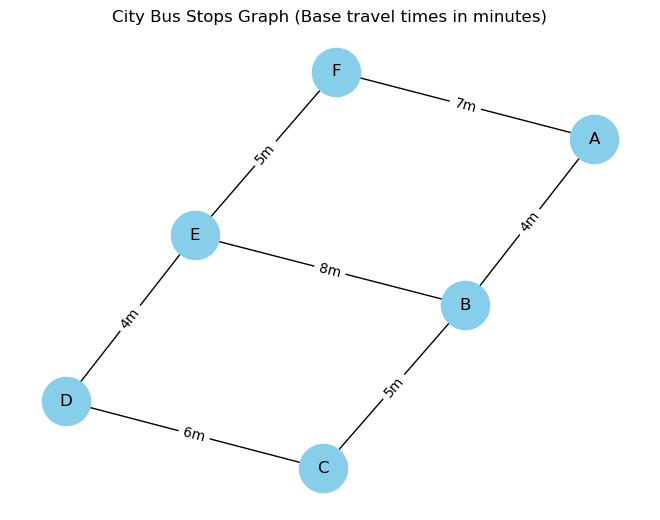

   timestamp  bus_id  u  v  ride_time
0          0       0  A  B   4.082026
1          0       1  F  A   5.800079
2          0       2  E  D   3.689369
3          1       0  A  B   4.320447
4          1       1  F  A   6.533779


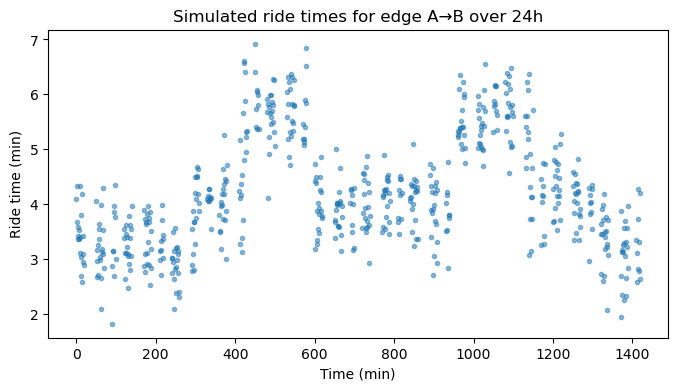

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- PARAMETERS ---
np.random.seed(0)
num_minutes = 60 * 24  # one day (1440 timestamps)
num_buses = 3

# --- DEFINE SIMPLE CITY GRAPH ---
# 6 stops (nodes)
G = nx.Graph()
G.add_edges_from([
    ("A", "B", {"base_time": 4}),
    ("B", "C", {"base_time": 5}),
    ("C", "D", {"base_time": 6}),
    ("D", "E", {"base_time": 4}),
    ("E", "F", {"base_time": 5}),
    ("F", "A", {"base_time": 7}),  # makes loop
    ("B", "E", {"base_time": 8}),  # shortcut edge
])

# visualize graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1200, node_color='skyblue', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['base_time']}m" for u, v, d in G.edges(data=True)})
plt.title("City Bus Stops Graph (Base travel times in minutes)")
plt.show()

# --- DEFINE BUS ROUTES ---
bus_routes = {
    0: ["A", "B", "C", "D", "E", "F", "A"],  # full loop
    1: ["B", "E", "F", "A", "B"],              # shorter loop
    2: ["C", "B", "A", "F", "E", "D", "C"],    # reverse pattern
}

# --- SIMULATE EVENTS ---
events = []

# Congestion pattern: peak hours have longer times
for t in range(num_minutes):  # each minute of the day
    hour = t // 60
    congestion_factor = 1.0
    if 7 <= hour <= 9 or 16 <= hour <= 18:
        congestion_factor = 1.4  # rush hour
    elif 22 <= hour or hour < 5:
        congestion_factor = 0.8  # night time

    for bus_id, route in bus_routes.items():
        route_pos = (t // 10 + bus_id * 2) % (len(route) - 1)  # every 10 minutes, bus moves
        u, v = route[route_pos], route[route_pos + 1]
        base_time = G[u][v]['base_time']
        noise = np.random.normal(0, 0.5)
        ride_time = max(1, base_time * congestion_factor + noise)
        events.append((t, bus_id, u, v, ride_time))

# Store events in DataFrame
df_events = pd.DataFrame(events, columns=['timestamp', 'bus_id', 'u', 'v', 'ride_time'])
print(df_events.head())

# --- Quick sanity check plot ---
plt.figure(figsize=(8,4))
subset = df_events[(df_events['u']=='A') & (df_events['v']=='B')]
plt.plot(subset['timestamp'], subset['ride_time'], '.', alpha=0.5)
plt.xlabel('Time (min)')
plt.ylabel('Ride time (min)')
plt.title('Simulated ride times for edge A→B over 24h')
plt.show()